# How to Fit Reflectivity Data In Python

## Simulating some Scattering


PHS/PG3, PAG1, Quencher2, PM/PE
C8O1H6 | C10O2H7 | C18S1H15 | C1F3S1O3 | C22N1H9


In [1]:
8 + 10 + 18 + 1 + 22, 1 + 2 + 4, 6 + 7 + 15 + 9, 3, 1

(59, 7, 37, 3, 1)

In [2]:
equation = "F0072"
TOK = "C59O7F3S1H37"
import matplotlib.pyplot as plt
import numpy as np

import pyref.fitting as fit

array([250. , 284. , 284.2, 284.6, 285. , 285.5, 286. , 286.5, 287. ,
       287.7, 288.6])

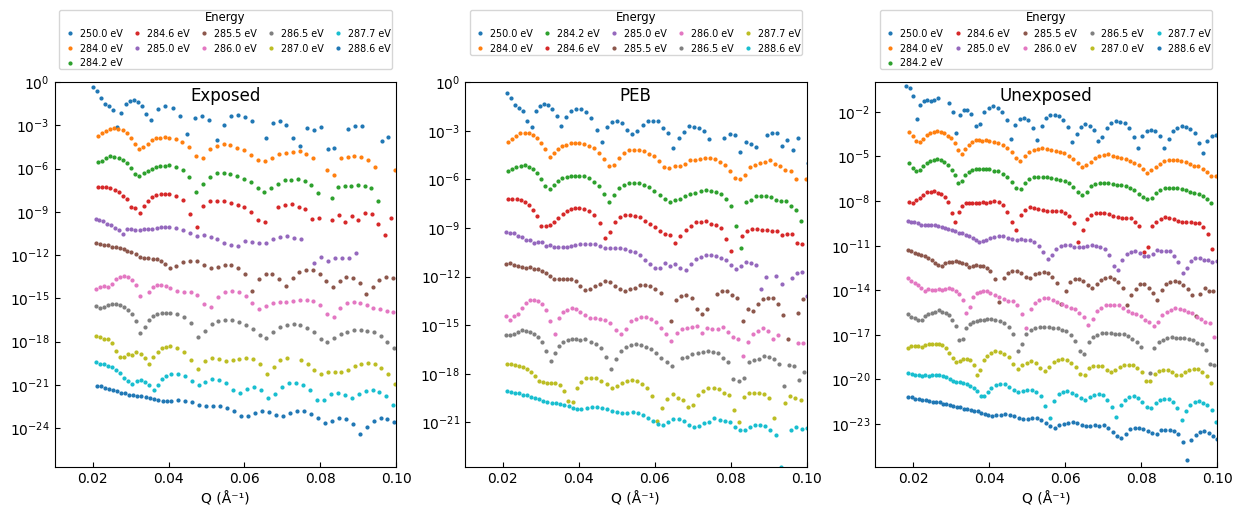

In [94]:
import pandas as pd
import seaborn as sns

df_exposed = pd.read_csv(
    "/home/hduva/projects/xrr_notebooks/photoresist/TOK_exps_UL_SOG3_4257.csv"
)
df_peb = pd.read_csv(
    "/home/hduva/projects/xrr_notebooks/photoresist/TOK_PEB_UL_SOG3_5077.csv"
)
df_un = pd.read_csv(
    "/home/hduva/projects/xrr_notebooks/photoresist/TOK_un_UL_SOG3_5433.csv"
)

df_groups = [df_exposed, df_peb, df_un]
names = ["Exposed", "PEB", "Unexposed"]
unique_energies = pd.concat(df_groups)["energy"].unique()

# Plot the datasets for each condition
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
for i, (ax, df) in enumerate(zip(axes, df_groups)):
    for j, g in enumerate(df.groupby("energy")):
        sf = 10 ** -(2 * j)
        energy = g[0]
        data = g[1]
        ax.errorbar(
            data["q"][15:],
            data["R"][15:] * sf,
            # yerr=0.08 * data["R"] + 0.2e-6 * data["q"],
            marker="o",
            linestyle="",
            label=f"{energy} eV",
            ms=2,
        )
        ax.set_yscale("log")
        ax.set_ylim(data["R"].min() * sf, 1)
    ax.set_xlim(0.01, 0.1)
    ax.set_xlabel("Q (Å⁻¹)")
    ax.legend(
        title="Energy",
        loc="upper center",
        ncols=5,
        fontsize="x-small",
        handletextpad=0.01,
        borderpad=0.1,
        columnspacing=0.5,
        title_fontsize="small",
        bbox_to_anchor=(0.5, 1.2),
    )
    ax.text(
        0.5,
        0.95,
        names[i],
        transform=ax.transAxes,
        ha="center",
        fontsize="large",
    )
unique_energies

In [162]:
def vacuum(energy):
    """Vacuum."""
    slab = fit.MaterialSLD("", 0, name=f"Vacuum_{energy}")(0, 0)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)
    return slab


def substrate(energy, thick=0, rough=1.2, density=2.44):
    """Substrate."""
    slab = fit.MaterialSLD(
        "Si", density=density, energy=energy, name=f"Substrate_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False, bounds=(2.4, 3))
    return slab


def sio2(energy, thick=10.1, rough=4, density=2.15):
    """SiO2."""
    slab = fit.MaterialSLD(
        "SiO2", density=density, energy=energy, name=f"Oxide_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=True, bounds=(1, 12))
    slab.rough.setp(vary=True, bounds=(1, 8))
    slab.sld.density.setp(vary=False, bounds=(1, 2.4))
    return slab


# def interface(energy, thick=100, rough=1.2, density=2.44):
#     """interface."""
#     if energy == 250:
#         slab = fit.MaterialSLD(
#             "Si1O4C67O11F3S1H5",
#             density=density,
#             energy=energy,
#             name=f"MIXED_{energy}",
#         )(thick, rough)
#         slab.sld.density.setp(vary=True, bounds=(0.5, 2.4))
#     slab.thick.setp(vary=True, bounds=(100, 500))
#     slab.rough.setp(vary=True, bounds=(0, 50))
#     return slab


def tok(energy, thick=300, rough=1.2, density=2.44):
    """TOK."""
    slab = fit.MaterialSLD("TOK", density=density, energy=energy, name=f"TOK_{energy}")(
        thick, rough
    )
    if energy == 250:
        slab.sld.density.setp(vary=True, bounds=(0.5, 3))
    else:
        slab = fit.SLD(complex(slab.sld), symmetry="uni", name=f"TOK_{energy}")(
            thick, rough
        )
        slab.sld.beta.setp(vary=True, bounds=(0, 5e-3))
        slab.sld.delta.setp(vary=True, bounds=(-5e-3, 5e-3))
    slab.thick.setp(vary=True, bounds=(100, 500))
    slab.rough.setp(vary=True, bounds=(0, 50))
    return slab


def sog(energy, thick=400, rough=1.2, density=2.44):
    """SOG."""
    slab = fit.MaterialSLD(
        "SiC8H20O4", density=density, energy=energy, name=f"SOG_{energy}"
    )(thick, rough)
    if energy == 250:
        slab.sld.density.setp(vary=True, bounds=(0.5, 3))
    else:
        slab = fit.SLD(complex(slab.sld), symmetry="uni", name=f"SOG_{energy}")(
            thick, rough
        )
        slab.sld.beta.setp(vary=True, bounds=(0, 5e-3))
        slab.sld.delta.setp(vary=True, bounds=(-5e-3, 5e-3))
    slab.thick.setp(vary=True, bounds=(300, 500))
    slab.rough.setp(vary=True, bounds=(0, 50))
    return slab


def construct_slab(energy, name=""):
    slab = vacuum(energy) | tok(energy) | sog(energy) | sio2(energy) | substrate(energy)
    slab.name = f"{name}_{energy}"
    return slab


def slab(energy, name=""):
    return construct_slab(energy, name)

In [163]:
# set the ticks to point inwards
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

The plot above gives the expected specular reflectivity of our input structure

# Fitting Data

Now that we have a model, we want to use it to fit some data. To do this, we need to
load in the data and build an Objective function that we can minimize. To do this we need
to read in the data stored in the `june_processed.parquet` file. I like to use polars
to read the data due to it's expressive queries, but plotting is better in pandas.


While it is nice to store things in a dataframe, we will need to cast it into a new form
for fitting. There is a converter in the pyref toolbox we can use


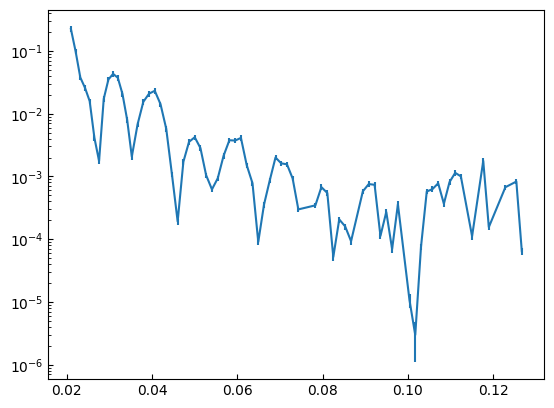

In [164]:
def data(df, energy):
    if df[df["energy"] == energy].empty:
        return None
    ds = fit.ReflectDataset(
        data=(
            df[df["energy"] == energy].q[15:],
            df[df["energy"] == energy].R[15:],
            0.1 * df[df["energy"] == energy].R[15:]
            + 0.2e-5 * df[df["energy"] == energy].q[15:] ** 0.1,
        )
    )
    return ds


fig, ax = data(df_peb, 250).plot()
ax.set_yscale("log")

In [165]:
from typing import Literal
import pyref.fitting.model
from refnx.analysis import Parameters, possibly_create_parameter, Parameter
from pyref.fitting.structure import Structure


class ReflectModel:
    r"""
    Reflectometry model for anisotropic interfaces.

    Parameters
    ----------
    structure : anisotropic_structure.PXR_Structure object
        The interfacial structure.
    scale : float or refnx.analysis.Parameter, optional
        scale factor. All model values are multiplied by this value before
        the background is added. This is turned into a Parameter during the
        construction of this object.
    bkg : float or refnx.analysis.Parameter, optional
        Q-independent constant background added to all model values. This is
        turned into a Parameter during the construction of this object.
    name : str, optional
        Name of the Model
    dq : float or refnx.analysis.Parameter, optional

        - `dq == 0` then no resolution smearing is employed.
        - `dq` is a float or refnx.analysis.Parameter
           a constant dQ/Q resolution smearing is employed.  For 5% resolution
           smearing supply 5.This value is turned into a Parameter during the
           construction of this object.

    Notes
    -----
    If `x_err` is supplied to the `model` method, dq becomes overriden. that
    overrides any setting given here.

    Adding q-smearing greatly reduces the current speed of the calculation.
    Data collected at ALS 11.0.1.2 over the carbon edge likely does not require any
    q-smearing.

    """

    def __init__(
        self,
        structure: Structure,
        energy: float | None = None,
        pol: Literal["s", "p", "sp", "ps"] = "s",
        name: str = "",
        *,
        scale: float = 1,
        bkg: float = 0,
        dq: float = 0.0,
        q_offset: float = 0.0,
        theta_offset: float = 0.0,
        phi: float = 0.0,
        backend: str = "uni",
    ) -> None:
        self.name = name
        self._parameters: Parameters | None = None
        self.backend = backend
        self._energy = energy  # [eV]
        self._phi = phi
        self._pol = pol  # Output polarization
        self._scale: Parameter = possibly_create_parameter(scale, name="scale")  # type: ignore

        self._bkg: Parameter = possibly_create_parameter(bkg, name="bkg")  # type: ignore
        self._q_offset: Parameter = possibly_create_parameter(  # type: ignore
            q_offset, name="q_offset"
        )

        # New model parameter energy_offset : 10/21/2021
        self._energy_offset: Parameter = possibly_create_parameter(  # type: ignore
            0.0, name="energy_offset", vary=False, bounds=(-1, 1)
        )
        structure.energy_offset = self._energy_offset

        # we can optimize the resolution (but this is always overridden by
        # x_err if supplied. There is therefore possibly no dependence on it.
        self._dq = possibly_create_parameter(dq, name="dq - resolution")

        # New model parameters for theta_offset
        self._theta_offset: Parameter = possibly_create_parameter(  # type: ignore
            theta_offset, name="theta_offset"
        )

        self._structure: Structure | None = None
        self.structure = structure

    def __call__(self, x, p=None, x_err=None):
        r"""
        Calculate the generative model.

        Parameters
        ----------
        x : float or np.ndarray
            q values for the calculation.
        p : refnx.analysis.Parameters, optional
            parameters required to calculate the model
        x_err : np.ndarray
            dq resolution smearing values for the dataset being considered.


        Returns
        -------
        reflectivity : np.ndarray
            Calculated reflectivity


        Note:
        -------
        Uses the assigned 'Pol' to determine the output state of 's-pol', 'p-pol' or
        both
        """
        return self.model(x, p=p, x_err=x_err)

    def __repr__(self):
        """Representation of the ReflectModel."""
        scale_repr = f"{self._scale!r}"

        return (
            f"ReflectModel({self._structure!r}, name={self.name!r},"
            f" scale={scale_repr}, bkg={self._bkg!r},"
            f" dq={self._dq!r},"
            f" q_offset={self._q_offset!r})"
        )

    @property
    def dq(self):
        r"""
        :class:`refnx.analysis.Parameter`.

            - `dq.value == 0`
               no resolution smearing is employed.
            - `dq.value > 0`
               a constant dQ/Q resolution smearing is employed.  For 5%
               resolution smearing supply 5. However, if `x_err` is supplied to
               the `model` method, then that overrides any setting reported
               here.

        """
        return self._dq

    @dq.setter
    def dq(self, value):
        self._dq.value = value  # type: ignore

    @property
    def scale(self):
        r"""
        :class:`refnx.analysis.Parameter`.
        """
        if hasattr(self, "_scale"):
            return self._scale
        else:
            return None

    @scale.setter
    def scale(self, value):
        if hasattr(self, "_scale"):
            self._scale.value = value  # type: ignore
        else:
            self._scale = value  # type: ignore

    @property
    def bkg(self):
        r"""
        :class:`refnx.analysis.Parameter`.

          - linear background added to all model values.
        """
        return self._bkg

    @bkg.setter
    def bkg(self, value):
        self._bkg.value = value  # type: ignore

    @property
    def q_offset(self):
        r"""
        :class:`refnx.analysis.Parameter`.

          - offset in q-vector due to experimental error
        """
        return self._q_offset

    @q_offset.setter
    def q_offset(self, value):
        self._q_offset.value = value  # type: ignore

    @property
    def theta_offset(self):
        r"""
        :class:`refnx.analysis.Parameter`.

          - offset in theta for both polarizations due to experimental error
        """
        return self._theta_offset

    @theta_offset.setter
    def theta_offset(self, value):
        self._theta_offset.value = value  # type: ignore

    @property
    def energy_offset(self) -> Parameter:
        r"""
        :class:`refnx.analysis.Parameter`.

        - offset in q-vector due to experimental error

        """
        return self._energy_offset

    @energy_offset.setter
    def energy_offset(self, value: float) -> None:
        self._energy_offset.value = value
        if self._structure is not None:
            self._structure.energy_offset = self._energy_offset

    @property
    def energy(self):
        """
        Photon energy to evaluate the resonant reflectivity.

        Automatically updates all PXR_MaterialSLD objects associated with
        self.structure.

        Returns
        -------
            energy : float
                Photon energy of X-ray probe.
        """
        return self._energy

    @energy.setter
    def energy(self, energy):
        self._energy = energy

    @property
    def pol(self):
        """
        Polarization to calculate the resonant reflectivity.

            -`pol == 's'`
            Calculation returns s-polarization only.
            -`pol == 'p'`
            Calculation returns p-polarization only.
            -`pol == 'sp' or 'ps'`
            Calulation returns concatenate in order of input.

        Returns
        -------
            pol : str
                Linear polarizations state of incident raw
        """
        return self._pol

    @pol.setter
    def pol(self, pol):
        self._pol = pol

    @property
    def phi(self):
        """
        Azimuthal angle of incidence [deg]. Only used with a biaxial calculation.

        Returns
        -------
            phi : float
                Azimuthal angle of incidence used in calculation.
        """
        return self._phi

    @phi.setter
    def phi(self, phi) -> None:
        self._phi = phi

    def _model(self, x, p=None, x_err=None):
        """
        Calculate the reflectivity model internals.

        This internal method handles parameter updates, q-vector adjustments,
        and theta offset corrections before calculating reflectivity.

        Parameters
        ----------
        x : np.ndarray
            q values for the calculation.
        p : refnx.analysis.Parameters, optional
            parameters required to calculate the model
        x_err : np.ndarray or float
            dq resolution smearing values for the dataset being considered.

        Returns
        -------
        tuple
            (qvals, qvals_1, qvals_2, refl, tran, components)
            - qvals: q values used for calculation
            - qvals_1, qvals_2: q values for first and second polarization
            - refl: reflectivity matrix
            - tran: transmission matrix
            - components: additional calculation components
        """
        # Update parameters if provided
        if p is not None:
            self.parameters.pvals = np.array(p)  # type: ignore

        # Use object's dq if x_err is not provided
        if x_err is None:
            x_err = float(self.dq)

        # Prepare common model parameters
        model_input = {
            "slabs": self.structure.slabs(),  # type: ignore
            "tensor": self.structure.tensor(energy=self.energy),  # type: ignore
            "energy": self.energy,
            "phi": self.phi,
            "scale_s": 1,
            "scale_p": 1,
            "bkg": self.bkg.value,  # type: ignore
            "dq": x_err,
            "backend": self.backend,
        }

        # Wavelength in Angstroms
        wavelength = 12398.42 / self.energy  # type: ignore

        # Handle polarization-specific adjustments
        if self.pol in ("sp", "ps"):
            # Find where q values split by detecting largest gap
            concat_loc = np.argmax(np.abs(np.diff(x)))
            qvals_1 = x[: concat_loc + 1]
            qvals_2 = x[concat_loc + 1 :]
            num_q = max(
                len(x),
                concat_loc + 50,  # type: ignore
            )  # Ensure sufficient points for interpolation

            # Convert q to theta (in degrees)
            theta_s = np.arcsin(qvals_1 * wavelength / (4 * np.pi)) * 180 / np.pi
            theta_p = np.arcsin(qvals_2 * wavelength / (4 * np.pi)) * 180 / np.pi

            # Apply polarization-specific angle offsets
            theta_s += self.theta_offset.value  # type: ignore
            theta_p += self.theta_offset.value  # type: ignore

            # Convert back to q
            qvals_1 = (4 * np.pi / wavelength) * np.sin(theta_s * np.pi / 180)
            qvals_2 = (4 * np.pi / wavelength) * np.sin(theta_p * np.pi / 180)

            # Create array for calculation and output
            x = np.concatenate([qvals_1, qvals_2])
            qvals = np.linspace(np.min(x), np.max(x), num_q)

        elif self.pol == "s":
            # Convert to theta, apply s-polarization offset, convert back to q
            theta = np.arcsin(x * wavelength / (4 * np.pi)) * 180 / np.pi
            theta += self.theta_offset.value  # type: ignore
            qvals = (4 * np.pi / wavelength) * np.sin(theta * np.pi / 180)
            qvals_1 = qvals_2 = qvals

        elif self.pol == "p":
            # Convert to theta, apply p-polarization offset, convert back to q
            theta = np.arcsin(x * wavelength / (4 * np.pi)) * 180 / np.pi
            theta += self.theta_offset.value  # type: ignore
            qvals = (4 * np.pi / wavelength) * np.sin(theta * np.pi / 180)
            qvals_1 = qvals_2 = qvals

        else:
            # No polarization specified, use raw q values
            qvals = qvals_1 = qvals_2 = x

        # Apply q offset and calculate reflectivity
        refl, tran, *components = pyref.fitting.model.reflectivity(  # type: ignore
            qvals + self.q_offset.value,  # type: ignore
            **model_input,  # type: ignore
        )

        return qvals, qvals_1, qvals_2, refl * self._scale.value, tran, components

    def model(self, x, p=None, x_err=None):
        r"""
        Calculate the reflectivity of this model.

        Parameters
        ----------
        x : float or np.ndarray
            q or E values for the calculation.
            specifiy self.qval to be any value to fit energy-space
        p : refnx.analysis.Parameters, optional
            parameters required to calculate the model
        x_err : np.ndarray
            dq resolution smearing values for the dataset being considered.

        Returns
        -------
        reflectivity : np.ndarray
            Calculated reflectivity. Output is dependent on `self.pol`

        """
        qvals, qvals_1, qvals_2, refl, tran, components = self._model(x, p, x_err)

        # Return result based on desired polarization:

        if self.pol == "s":
            output = refl[:, 1, 1]
        elif self.pol == "p":
            output = refl[:, 0, 0]
        elif self.pol == "sp":
            spol_model = np.interp(qvals_1, qvals, refl[:, 1, 1])  # type: ignore
            ppol_model = np.interp(qvals_2, qvals, refl[:, 0, 0])  # type: ignore
            output = np.concatenate([spol_model, ppol_model])
        elif self.pol == "ps":
            spol_model = np.interp(qvals_2, qvals, refl[:, 1, 1])  # type: ignore
            ppol_model = np.interp(qvals_1, qvals, refl[:, 0, 0])  # type: ignore
            output = np.concatenate([ppol_model, spol_model])

        else:
            print("No polarizations were chosen for model")
            output = 0

        return output

    def anisotropy(self, x, p=None, x_err=None):
        """
        Calculate the anisotropy of the model.

        Properly accounts for theta offsets between s and p polarizations.
        """
        # Wavelength in Angstroms
        wavelength = 12398.42 / self.energy  # type: ignore

        # Convert x (q) to theta (in degrees)
        theta = np.arcsin(x * wavelength / (4 * np.pi)) * 180 / np.pi

        # Apply polarization-specific angle offsets
        theta_s = theta + self.theta_offset_s.value  # type: ignore
        theta_p = theta + self.theta_offset_p.value  # type: ignore

        # Convert back to q
        q_s = (4 * np.pi / wavelength) * np.sin(theta_s * np.pi / 180)
        q_p = (4 * np.pi / wavelength) * np.sin(theta_p * np.pi / 180)

        # Calculate reflectivity for both polarizations with their respective offsets
        old_pol = self.pol  # Save current polarization setting

        # Calculate s-polarization
        self.pol = "s"
        r_s = self.model(q_s, p)

        # Calculate p-polarization
        self.pol = "p"
        r_p = self.model(q_p, p)

        # Restore original polarization
        self.pol = old_pol

        # Calculate anisotropy
        anisotropy = (r_p - r_s) / (r_p + r_s)

        return anisotropy

    def logp(self):
        r"""
        Additional log-probability terms for the reflectivity model.

        Do not
        include log-probability terms for model parameters, these are
        automatically included elsewhere.

        Returns
        -------
        logp : float
            log-probability of structure.

        """
        return self.structure.logp()  # type: ignore

    @property
    def structure(self):
        r"""
        :class:`PRSoXR.PXR_Structure`.

           - object describing the interface of a reflectometry sample.
        """
        return self._structure

    @structure.setter
    def structure(self, structure) -> None:
        self._structure = structure
        if self._structure is not None:
            self._structure.energy_offset = self._energy_offset
        p = Parameters(name="instrument parameters")
        p.extend(
            [
                self.scale,
                self.bkg,
                self.dq,
                self.q_offset,
                self.energy_offset,
                self.theta_offset,
            ]
        )

        self._parameters = Parameters(name=self.name)
        self._parameters.extend([p, structure.parameters])

    @property
    def parameters(self):
        r"""
        :class:`refnx.analysis.Parameters`.

           - parameters associated with this model.
        """
        self.structure = self._structure
        return self._parameters

    @classmethod
    def build_model(
        cls, energy: float, structure: Structure, data, *, name=""
    ) -> fit.ReflectModel:
        """
        Defualt model builder.

        Parameters
        ----------
        energy : float
            Photon energy to evaluate the resonant reflectivity.
        structure : Structure
            The interfacial structure.
        data : XrayReflectDataset
            The dataset to fit the model to.

        Returns
        -------
        ReflectModel
            A ReflectModel instance with the specified energy and structure.
        """
        model = cls(
            structure,
            pol="sp",
            energy=energy,
            name=f"{name}_{energy}",
            scale=1.0,
        )
        model.theta_offset.setp(vary=True, bounds=(-0.8, 0.8))
        model.scale.setp(vary=True, bounds=(0.6, 1.4))
        return model  # type: ignore


100%|██████████| 500/500 [00:35<00:00, 14.27it/s]
5680.935955849532: : 34it [00:01, 28.27it/s] 
2262.946153448494: : 120it [00:08, 14.37it/s] 
100%|██████████| 500/500 [00:36<00:00, 13.71it/s]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

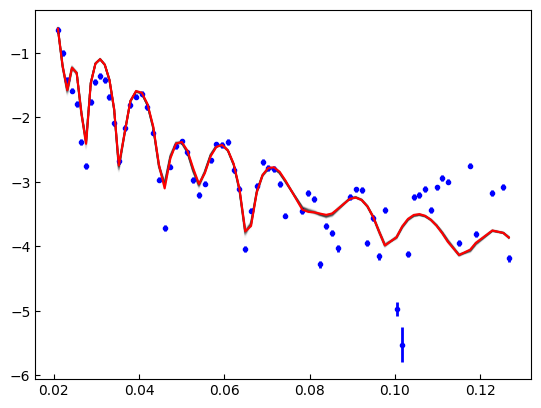

In [174]:
def _de(objective):
    result = fit.CurveFitter(objective=objective)
    result.fit(
        "differential_evolution", workers=-1, target="nlpost", updating="deferred"
    )
    return objective, result


def _lbfgs(objective) -> tuple[fit.Objective, fit.CurveFitter]:
    result = fit.CurveFitter(objective=objective)
    result.fit("L-BFGS-B", target="nlpost")
    return objective, result


def _mcmc(obj, chains, steps, random_state):
    result = fit.CurveFitter(objective=obj, nwalkers=chains, ntemps=2)
    result.initialise(pos="jitter", random_state=random_state)
    result.sample(steps=steps, nthin=steps // 10, random_state=random_state)
    return obj, result


def obj(df, energy, name=""):
    model = ReflectModel(
        structure=slab(energy, name),  # The slab we just created
        energy=energy,  # Energy in eV
        pol="s",  # S and P-polarized light
        theta_offset=10,
        name=name,  # Name of the model
    )

    model.scale.setp(vary=True, value=1, bounds=(1e-2, 1e2))
    model.theta_offset.setp(vary=True, value=-0, bounds=(-1, 1))
    ds = data(df, energy)
    if ds is None:
        return None
    bkg = ds.y.min()
    model.bkg.setp(
        value=bkg, bounds=(bkg, np.quantile(ds.y, 0.4)), vary=False
    )  # Set the background to a fixed value

    o = fit.Objective(
        data=ds,  # The data we just created
        model=model,  # The model we just created
        name=name,  # Name of the objective
        transform=fit.Transform("logY"),
    )
    # we also want to apply this little modification to the logp of the system.
    # lpe = fit.LogpExtra(o)
    # o.logp_extra = lpe
    o_fit, _ = _mcmc(o, 200, 500, 42)
    o_fit, _ = _lbfgs(o)
    o_fit, _ = _de(o_fit)
    o_fit, _ = _mcmc(o, 200, 500, 42)

    return o_fit


obj(df_peb, 250, "PEB").plot(samples=100)
# plt.ylim((-8, 0))

## Investigating Parameters

Now we want to ensure we are fitting the correct parameters to the system, and ensure
everything is being varried successfully. To do this we can look at all the possible
parameters that are used to define this system.


In [128]:
from refnx.analysis import Parameters
import sigfig


def all_parameters(parameter_group):
    if isinstance(parameter_group, Parameters):
        params = []
        for param in parameter_group:
            params.extend(all_parameters(param))
        return params
    else:
        return [parameter_group]


def print_parameters(obj):
    """Print all parameters in the object."""
    param_list = all_parameters(obj.parameters)
    print(f"Number of parameters: {len(param_list)}")
    print(f"Varying parameters: {len(obj.varying_parameters())}")
    print("-" * 82)
    for param in param_list:
        vary_status = "✓" if param.vary else "✗"
        color = (
            "\033[94m" if param.vary else "\033[91m"
        )  # Light blue for vary=True, red for vary=False
        reset_color = "\033[0m"  # Reset to default color
        if param.stderr and param.stderr != 0:
            stderr = sigfig.round(param.stderr, sigfigs=1)
            val = round(param.value, -int(np.floor(np.log10(param.stderr))))
            val_str = f"{val:10.3f}"
            stderr_str = f"{stderr:g}"  # Remove trailing zeros
        else:
            stderr_str = "0"
            val_str = (
                f"{param.value:10.3f}"
                if param.name != "bkg"
                else f"{param.value:10.3g}"
            )

        print(
            f"|{color}{vary_status} | {param.name:30} | {val_str} ± {stderr_str:>8} | {str(param.bounds):18}{reset_color} |"
        )
    print("-" * 82)

In [129]:
import copy

100%|██████████| 500/500 [00:42<00:00, 11.90it/s]
470.0129857327415: : 71it [00:02, 29.27it/s] 
471.3702752399592: : 138it [00:07, 17.79it/s] 
100%|██████████| 500/500 [00:49<00:00, 10.01it/s]
2368.660681127955: : 50it [00:02, 23.46it/s] 
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/refnx/analysis/objective.py:796: LinAlgWarning: The following Parameters have no effect on Objective.residuals, please consider fixing them.
[Parameter(value=0.0, name='SOG_284.0_rough', vary=True, bounds=Interval(lb=0.0, ub=50.0), constraint=None), Parameter(value=0.0011364249108134976, name='SOG_284.0_diso', vary=True, bounds=Interval(lb=-0.005, ub=0.005), constraint=None), Parameter(value=0.0006976335406021531, name='SOG_284.0_biso', vary=True, bounds=Interval(lb=0.0, ub=0.005), constraint=None)]
  warnings.warn(
1612.620445297454: : 50it [00:05,  8.61it/s] 
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/refnx/analysis/objective.py:796: LinAlgWarning: The f

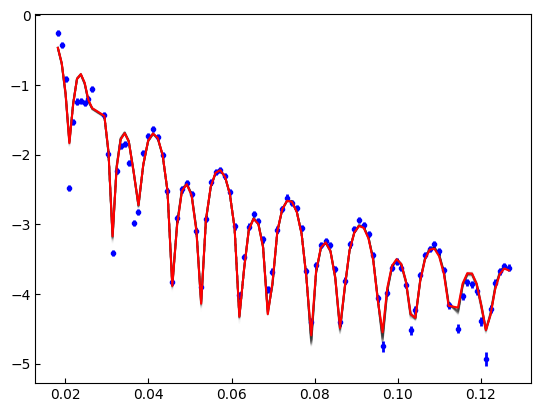

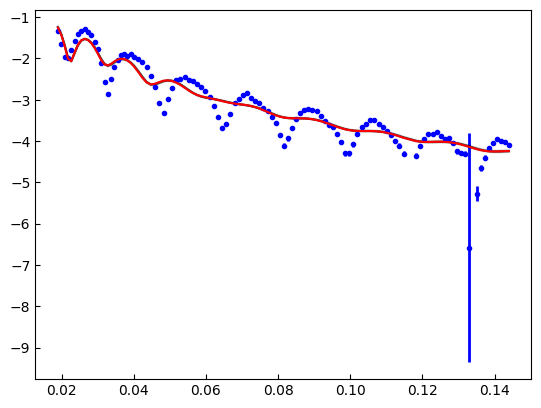

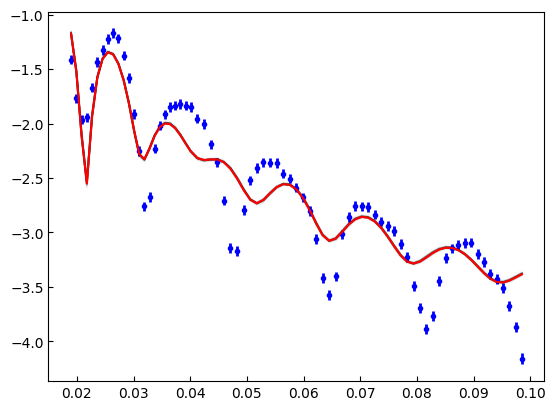

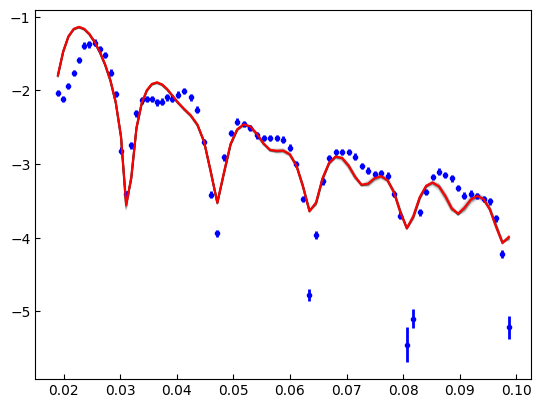

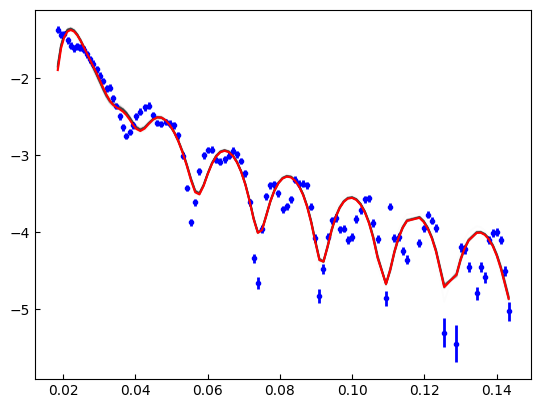

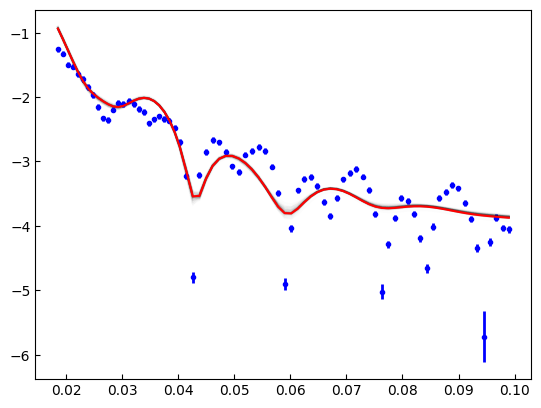

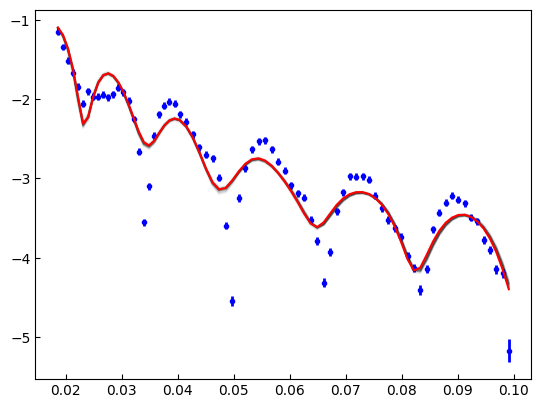

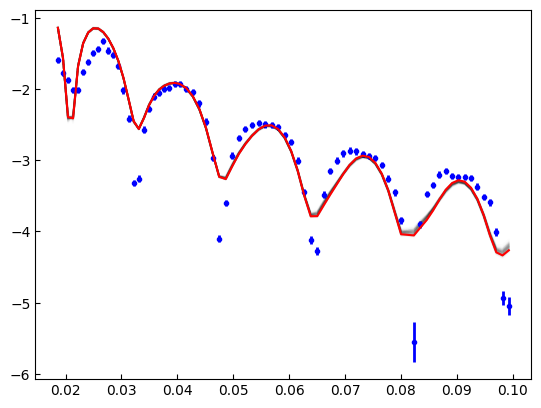

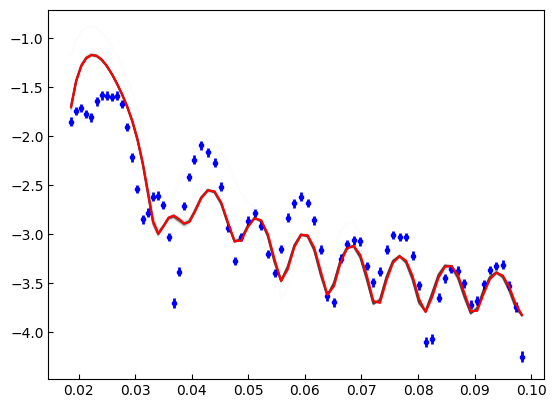

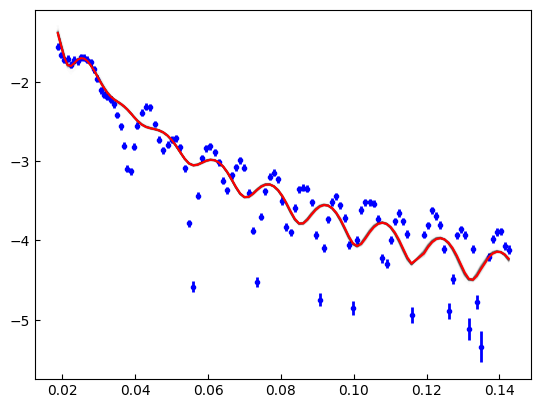

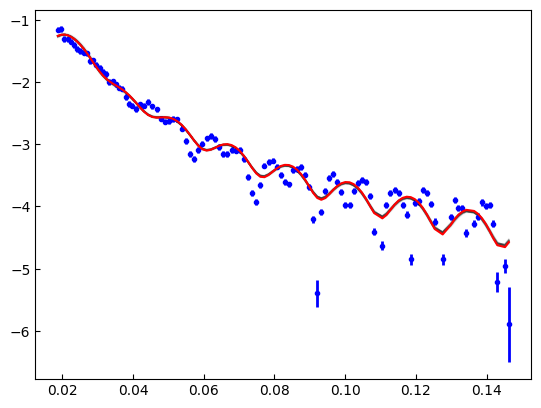

In [175]:
for e in unique_energies:
    obj(df_un, e, "UN").plot(samples=100)

In [144]:
from pyref.fitting.fitters import Fitter
from refnx.analysis.objective import GlobalObjective, Objective


def obj_list(df) -> list[Objective]:
    unique_energies = df["energy"].unique()
    objectives = [obj(df_un, energy, "Unexposed") for energy in unique_energies]
    return objectives


def global_obj(df):
    objectives = obj_list(df)
    if not objectives:
        return None
    constraint = objectives[0].model.structure
    for i, o in enumerate(objectives):
        if i == 0:
            continue
        if o is None:
            continue
        structure = o.model.structure
        for i, layer in enumerate(structure):
            layer.thick.setp(vary=None, constraint=constraint[i].thick)
            layer.rough.setp(vary=None, constraint=constraint[i].rough)
            if hasattr(layer.sld, "density"):
                layer.sld.density.setp(vary=None, constraint=constraint[i].sld.density)
    return fit.GlobalObjective(objectives)

In [145]:
from pyref.fitting.fitters import Fitter
from refnx.analysis.objective import GlobalObjective


def de(df) -> None | tuple[GlobalObjective, Fitter]:
    gobj = global_obj(df)
    if gobj is None:
        return None
    result = fit.CurveFitter(objective=gobj)
    result.fit("differential_evolution", workers=-1)
    return gobj, result


def mcmc(globj):
    gobj = copy.deepcopy(globj)
    fitter = fit.CurveFitter(objective=gobj, nwalkers=500)
    fitter.initialise("jitter")
    fitter.sample(2000, skip_check=True, pool=-1)
    return gobj, fitter

5136.2080207845975: : 80it [00:02, 28.25it/s]
3022.72750135334: : 72it [00:03, 23.61it/s]  
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/refnx/analysis/objective.py:796: LinAlgWarning: The following Parameters have no effect on Objective.residuals, please consider fixing them.
[Parameter(value=0.0015754168258631518, name='SOG_284.0_diso', vary=True, bounds=Interval(lb=-0.005, ub=0.005), constraint=None), Parameter(value=0.0006319283544453701, name='SOG_284.0_biso', vary=True, bounds=Interval(lb=0.0, ub=0.005), constraint=None)]
  warnings.warn(
3766.1958842297213: : 29it [00:01, 28.82it/s]
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/refnx/analysis/objective.py:796: LinAlgWarning: The following Parameters have no effect on Objective.residuals, please consider fixing them.
[Parameter(value=0.001499232207185841, name='SOG_284.2_diso', vary=True, bounds=Interval(lb=-0.005, ub=0.005), constraint=None), Parameter(value=0.0009371063885320002,

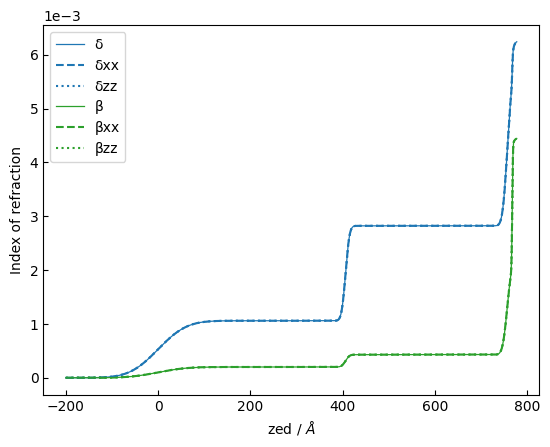

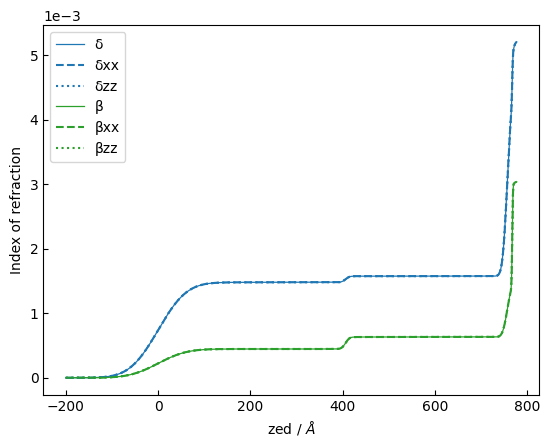

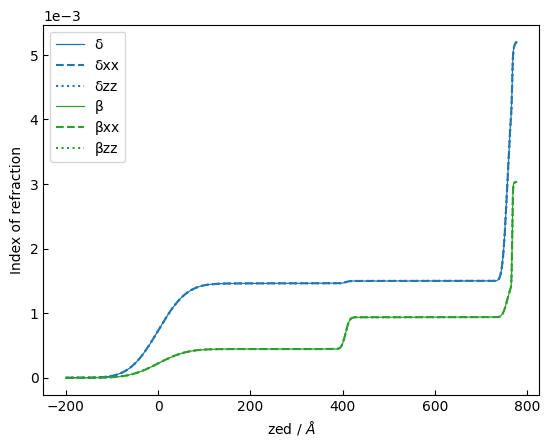

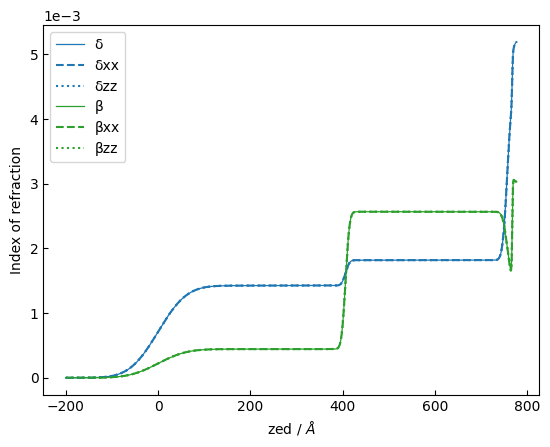

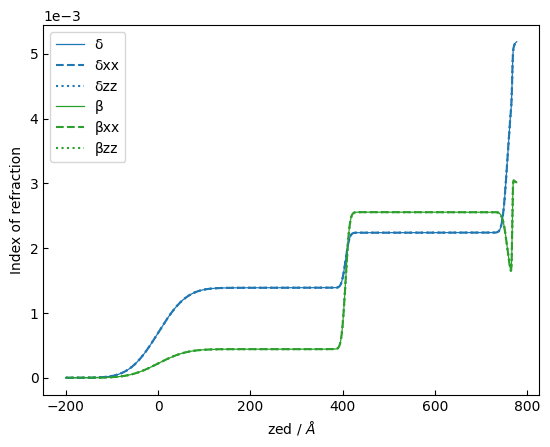

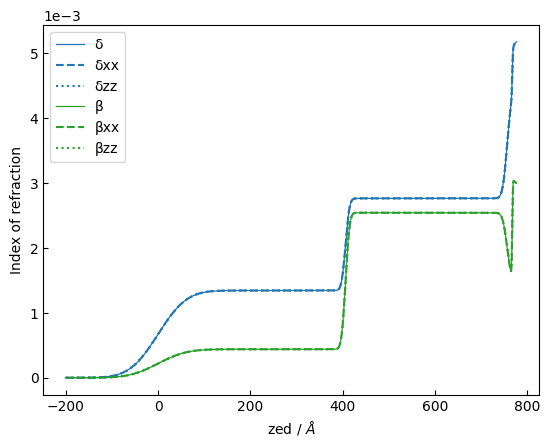

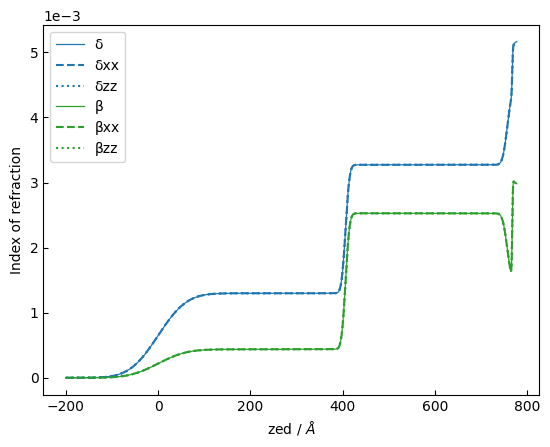

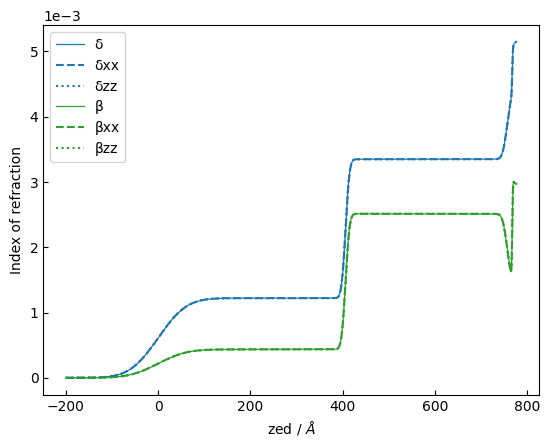

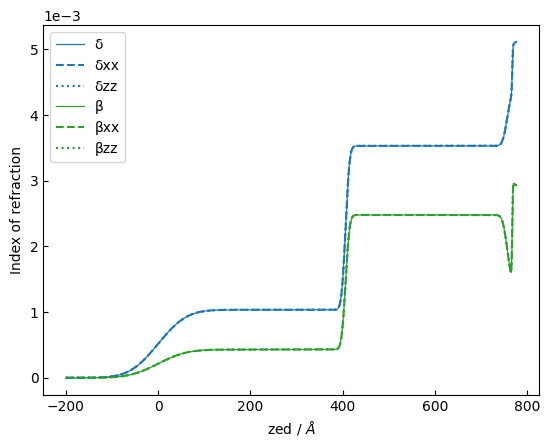

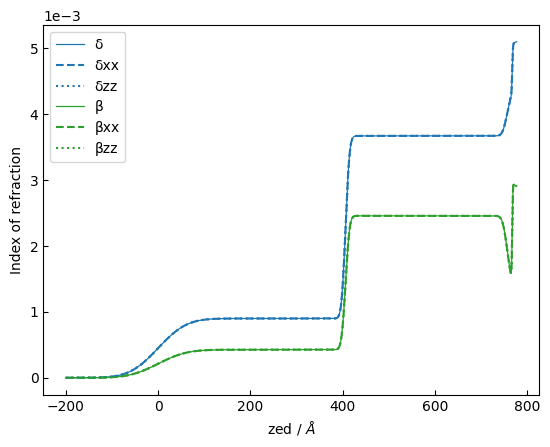

In [155]:
peb_fit, res = de(df_peb)
for objective in peb_fit.objectives:
    objective.model.structure.plot()

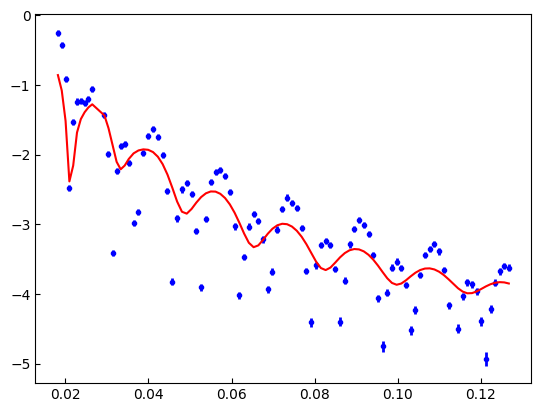

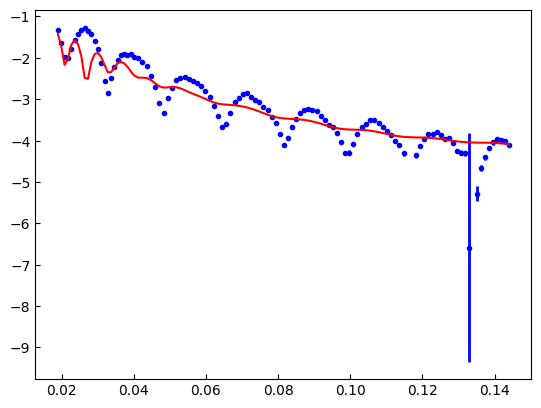

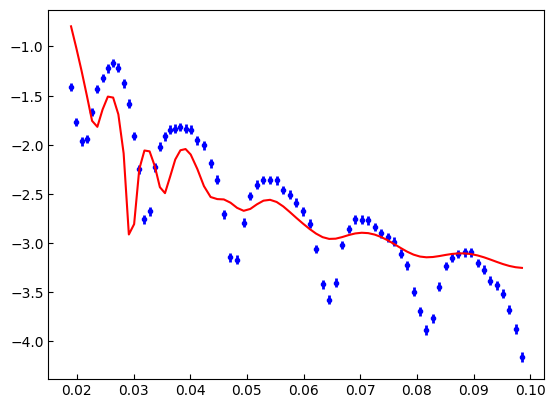

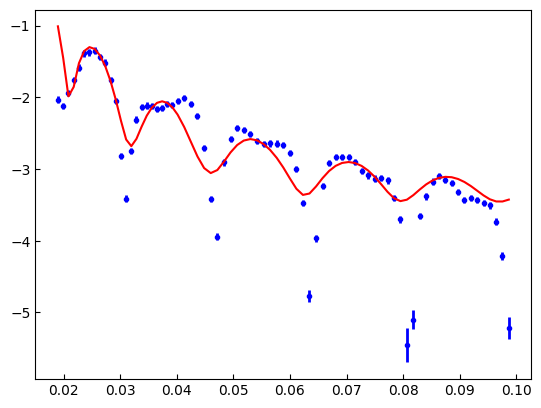

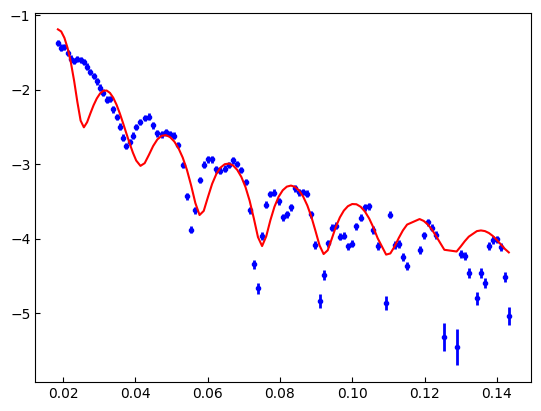

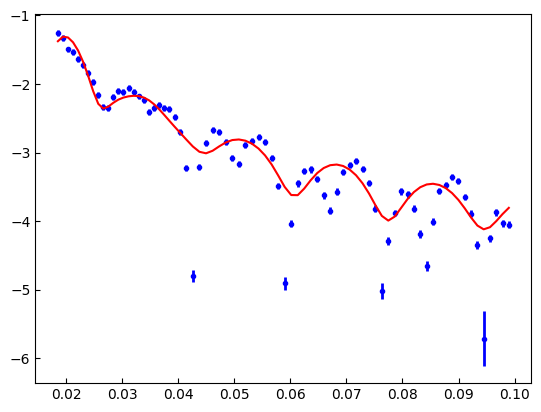

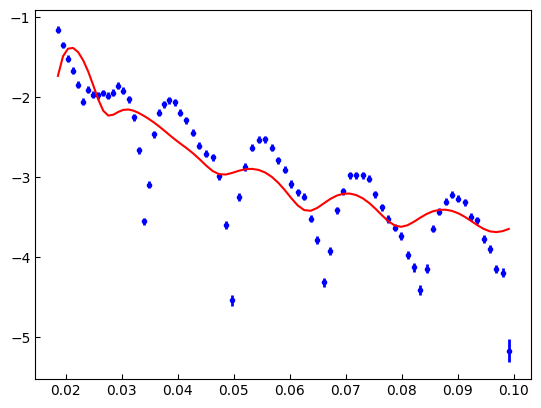

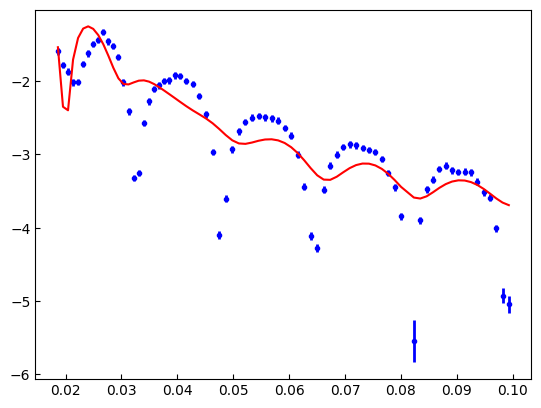

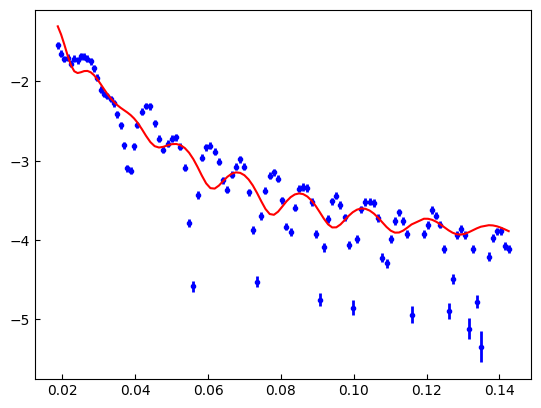

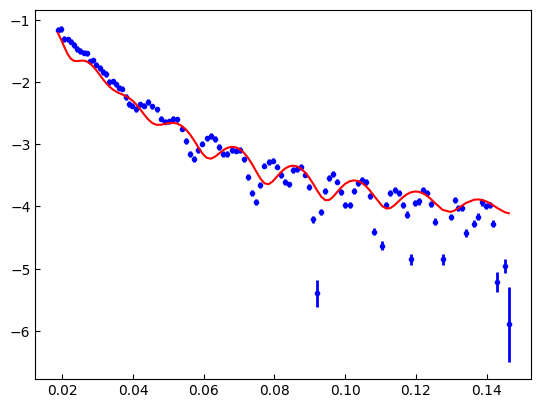

In [156]:
for objective in peb_fit.objectives:
    objective.plot()

(<Figure size 640x480 with 1 Axes>, <Axes: >)

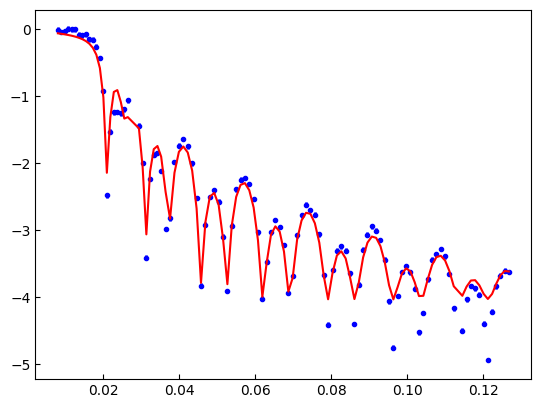

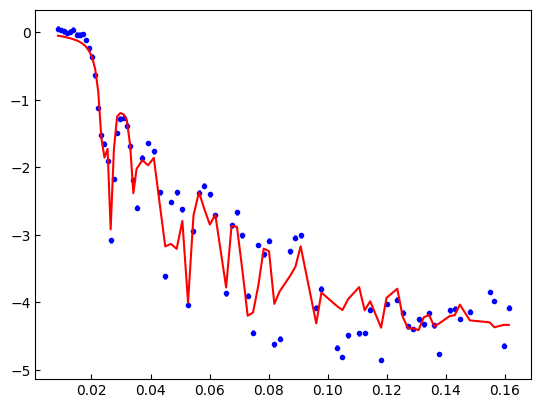

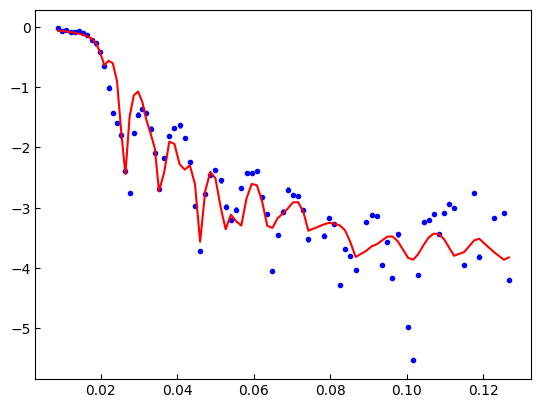

In [29]:
obj_unexposed.plot()
obj_exposed.plot()
obj_peb.plot()

In [15]:
obj_unexposed.model.bkg.setp(vary=False)
obj_unexposed.model.scale_s.setp(vary=False)
obj_unexposed.model.theta_offset_s.setp(vary=False)

obj_exposed.model.bkg.setp(vary=False)
obj_exposed.model.scale_s.setp(vary=False)
obj_exposed.model.theta_offset_s.setp(vary=False)

obj_peb.model.bkg.setp(vary=False)
obj_peb.model.scale_s.setp(vary=False)
obj_peb.model.theta_offset_s.setp(vary=False)


100%|██████████| 1000/1000 [01:00<00:00, 16.63it/s]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

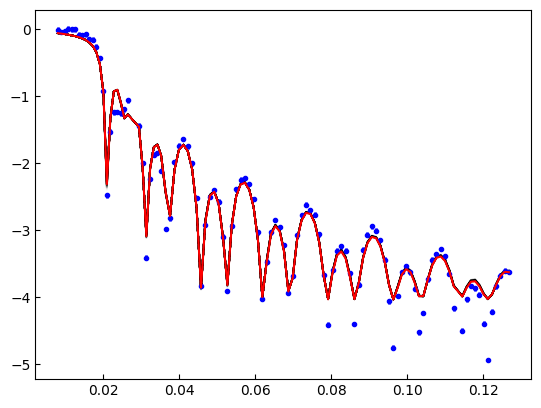

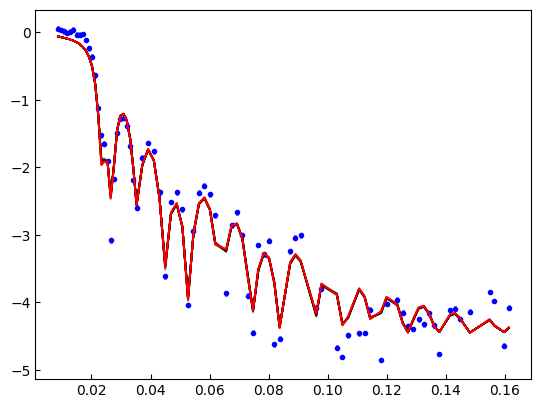

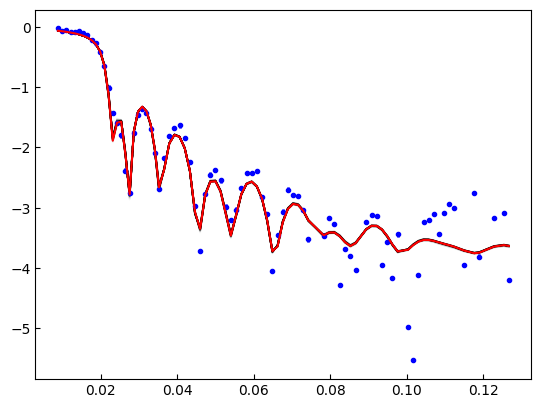

In [16]:
obj_unexposed_chained = copy.deepcopy(obj_unexposed)
obj_exposed_chained = copy.deepcopy(obj_exposed)
obj_peb_chained = copy.deepcopy(obj_peb)

fitter_unex_chained = fit.CurveFitter(objective=obj_unexposed_chained, nwalkers=200)
fitter_exp_chained = fit.CurveFitter(objective=obj_exposed_chained, nwalkers=200)
fitter_peb_chained = fit.CurveFitter(objective=obj_peb_chained, nwalkers=200)
fitter_unex_chained.initialise("jitter")
fitter_unex_chained.sample(
    1000, skip_check=True, pool=-1
)  # this will likely have a large initial condition number, so we skip the check and just sample
fitter_exp_chained.initialise("jitter")
fitter_exp_chained.sample(1000, skip_check=True, pool=-1)
fitter_peb_chained.initialise("jitter")
fitter_peb_chained.sample(1000, skip_check=True, pool=-1)

obj_unexposed_chained.plot(samples=200)
obj_exposed_chained.plot(samples=200)
obj_peb_chained.plot(samples=200)

/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>

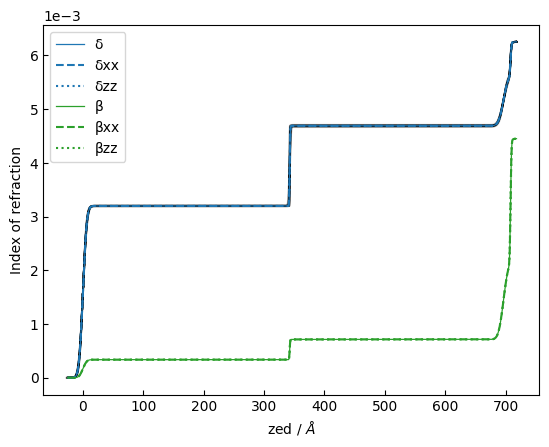

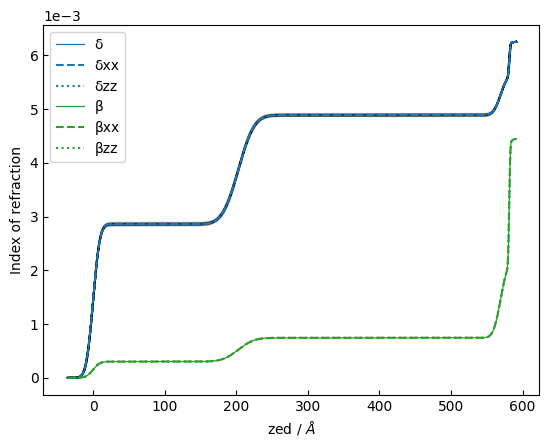

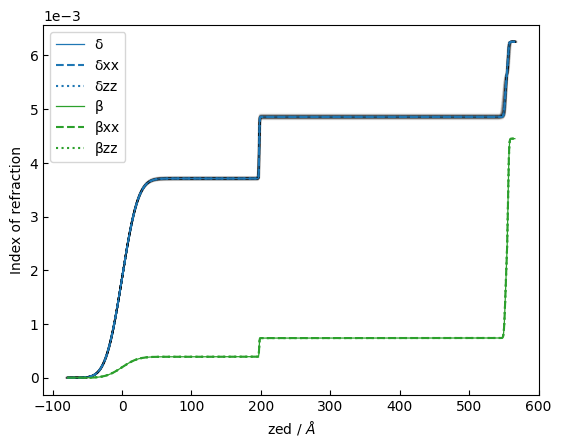

In [17]:
obj_unexposed_chained.model.structure.plot(samples=200)
obj_exposed_chained.model.structure.plot(samples=200)
obj_peb_chained.model.structure.plot(samples=200)


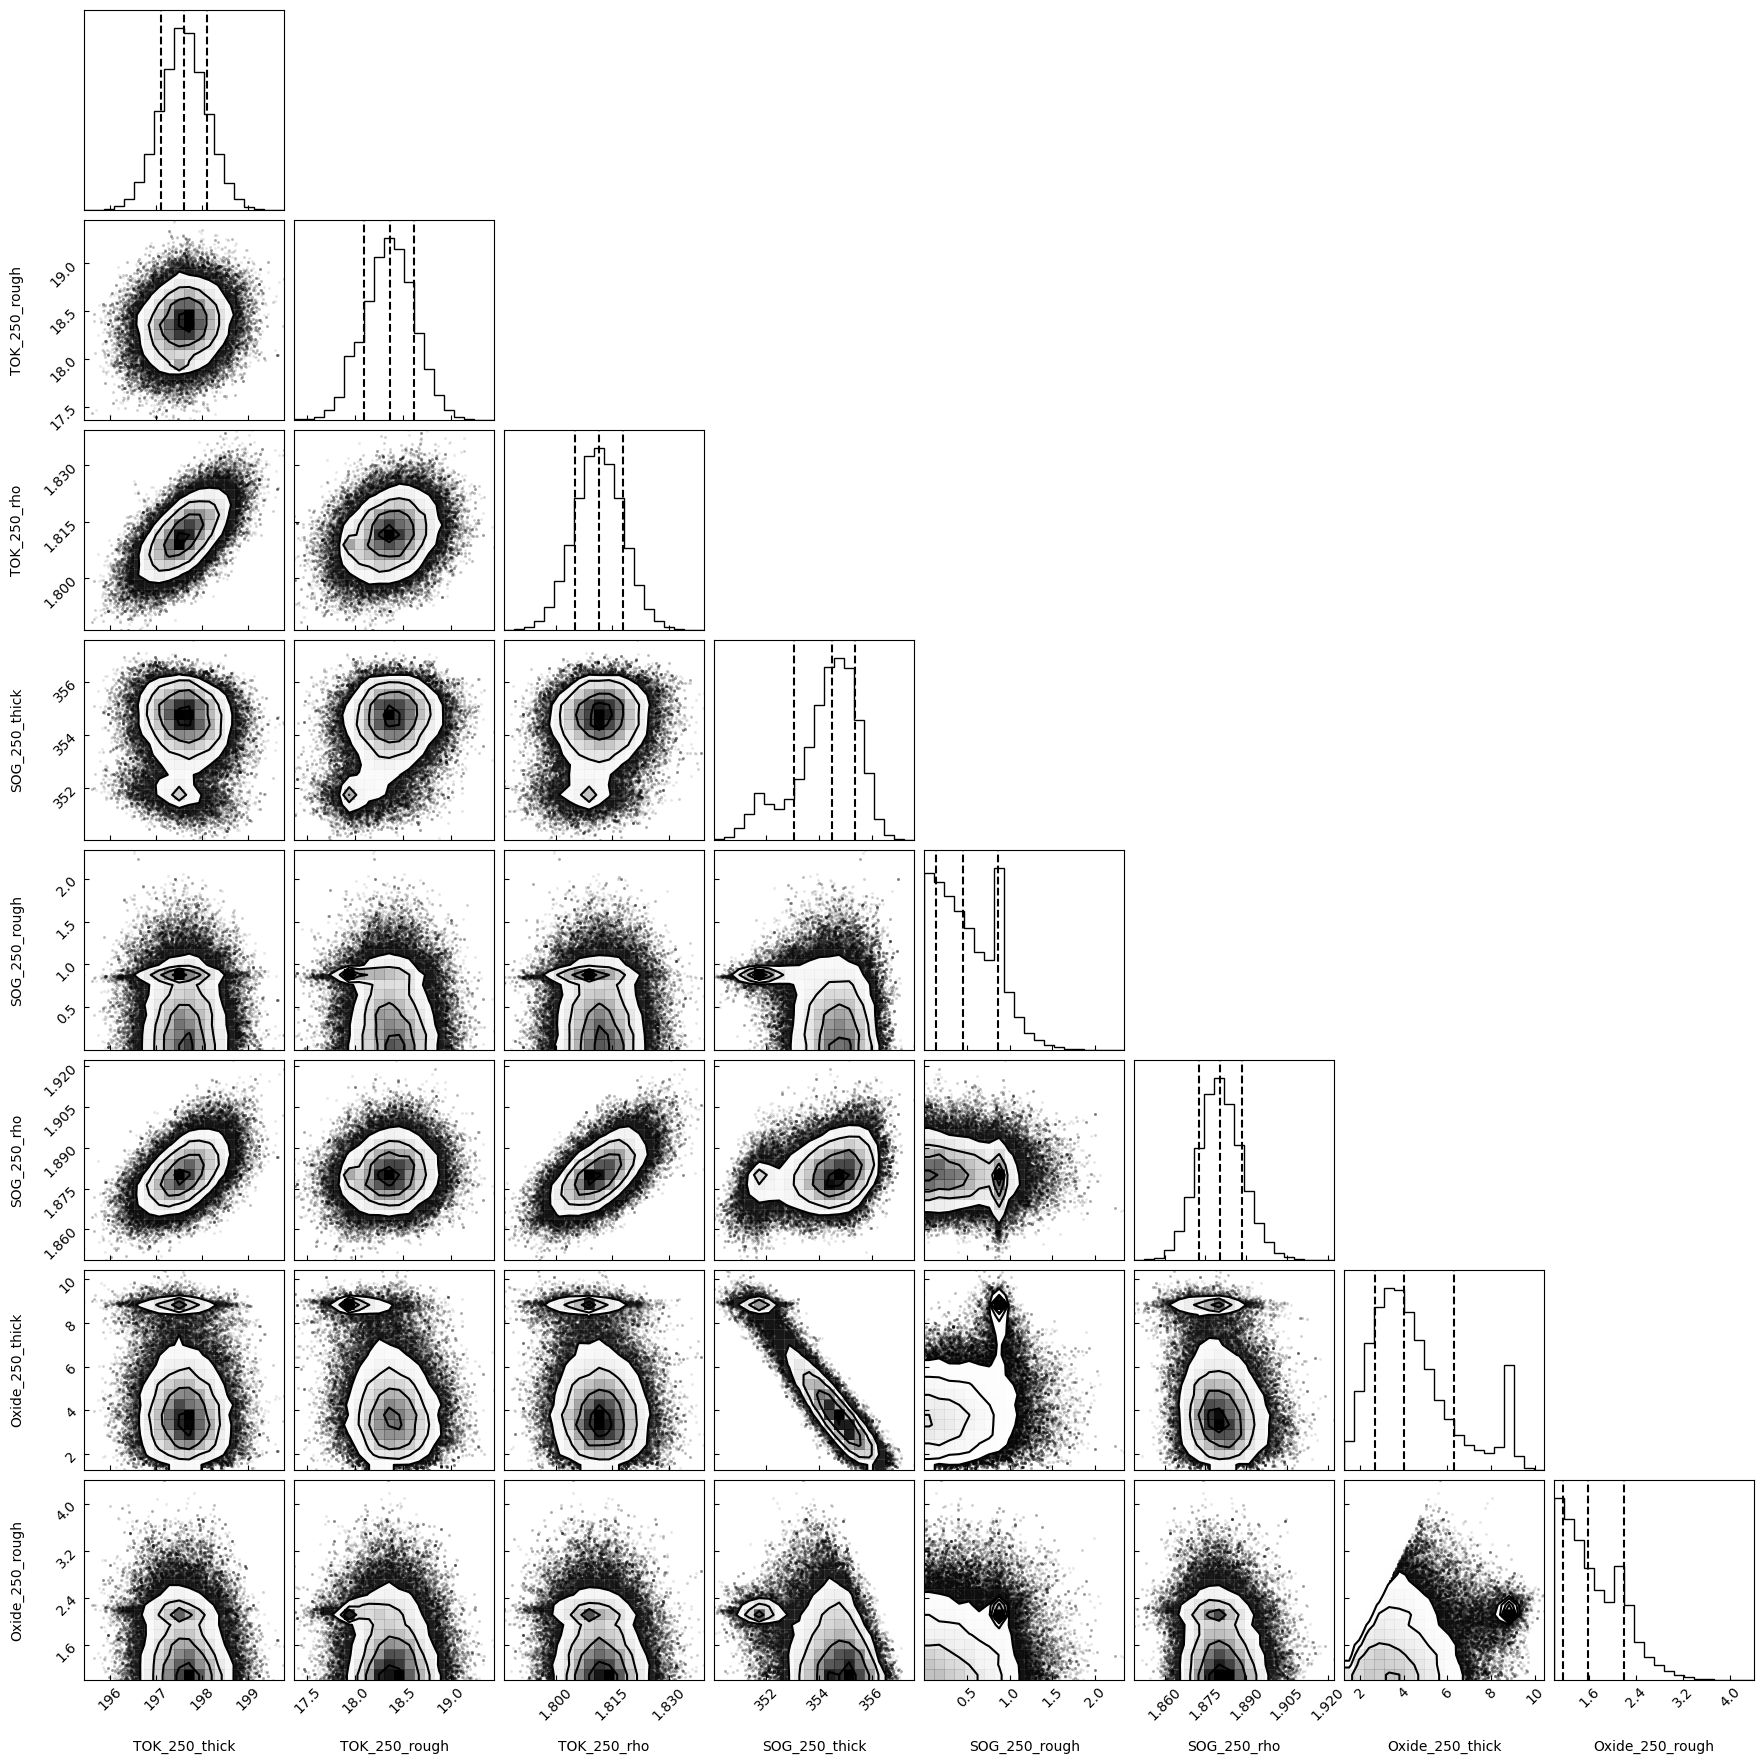

In [18]:
obj_peb_chained.corner()
plt.show()

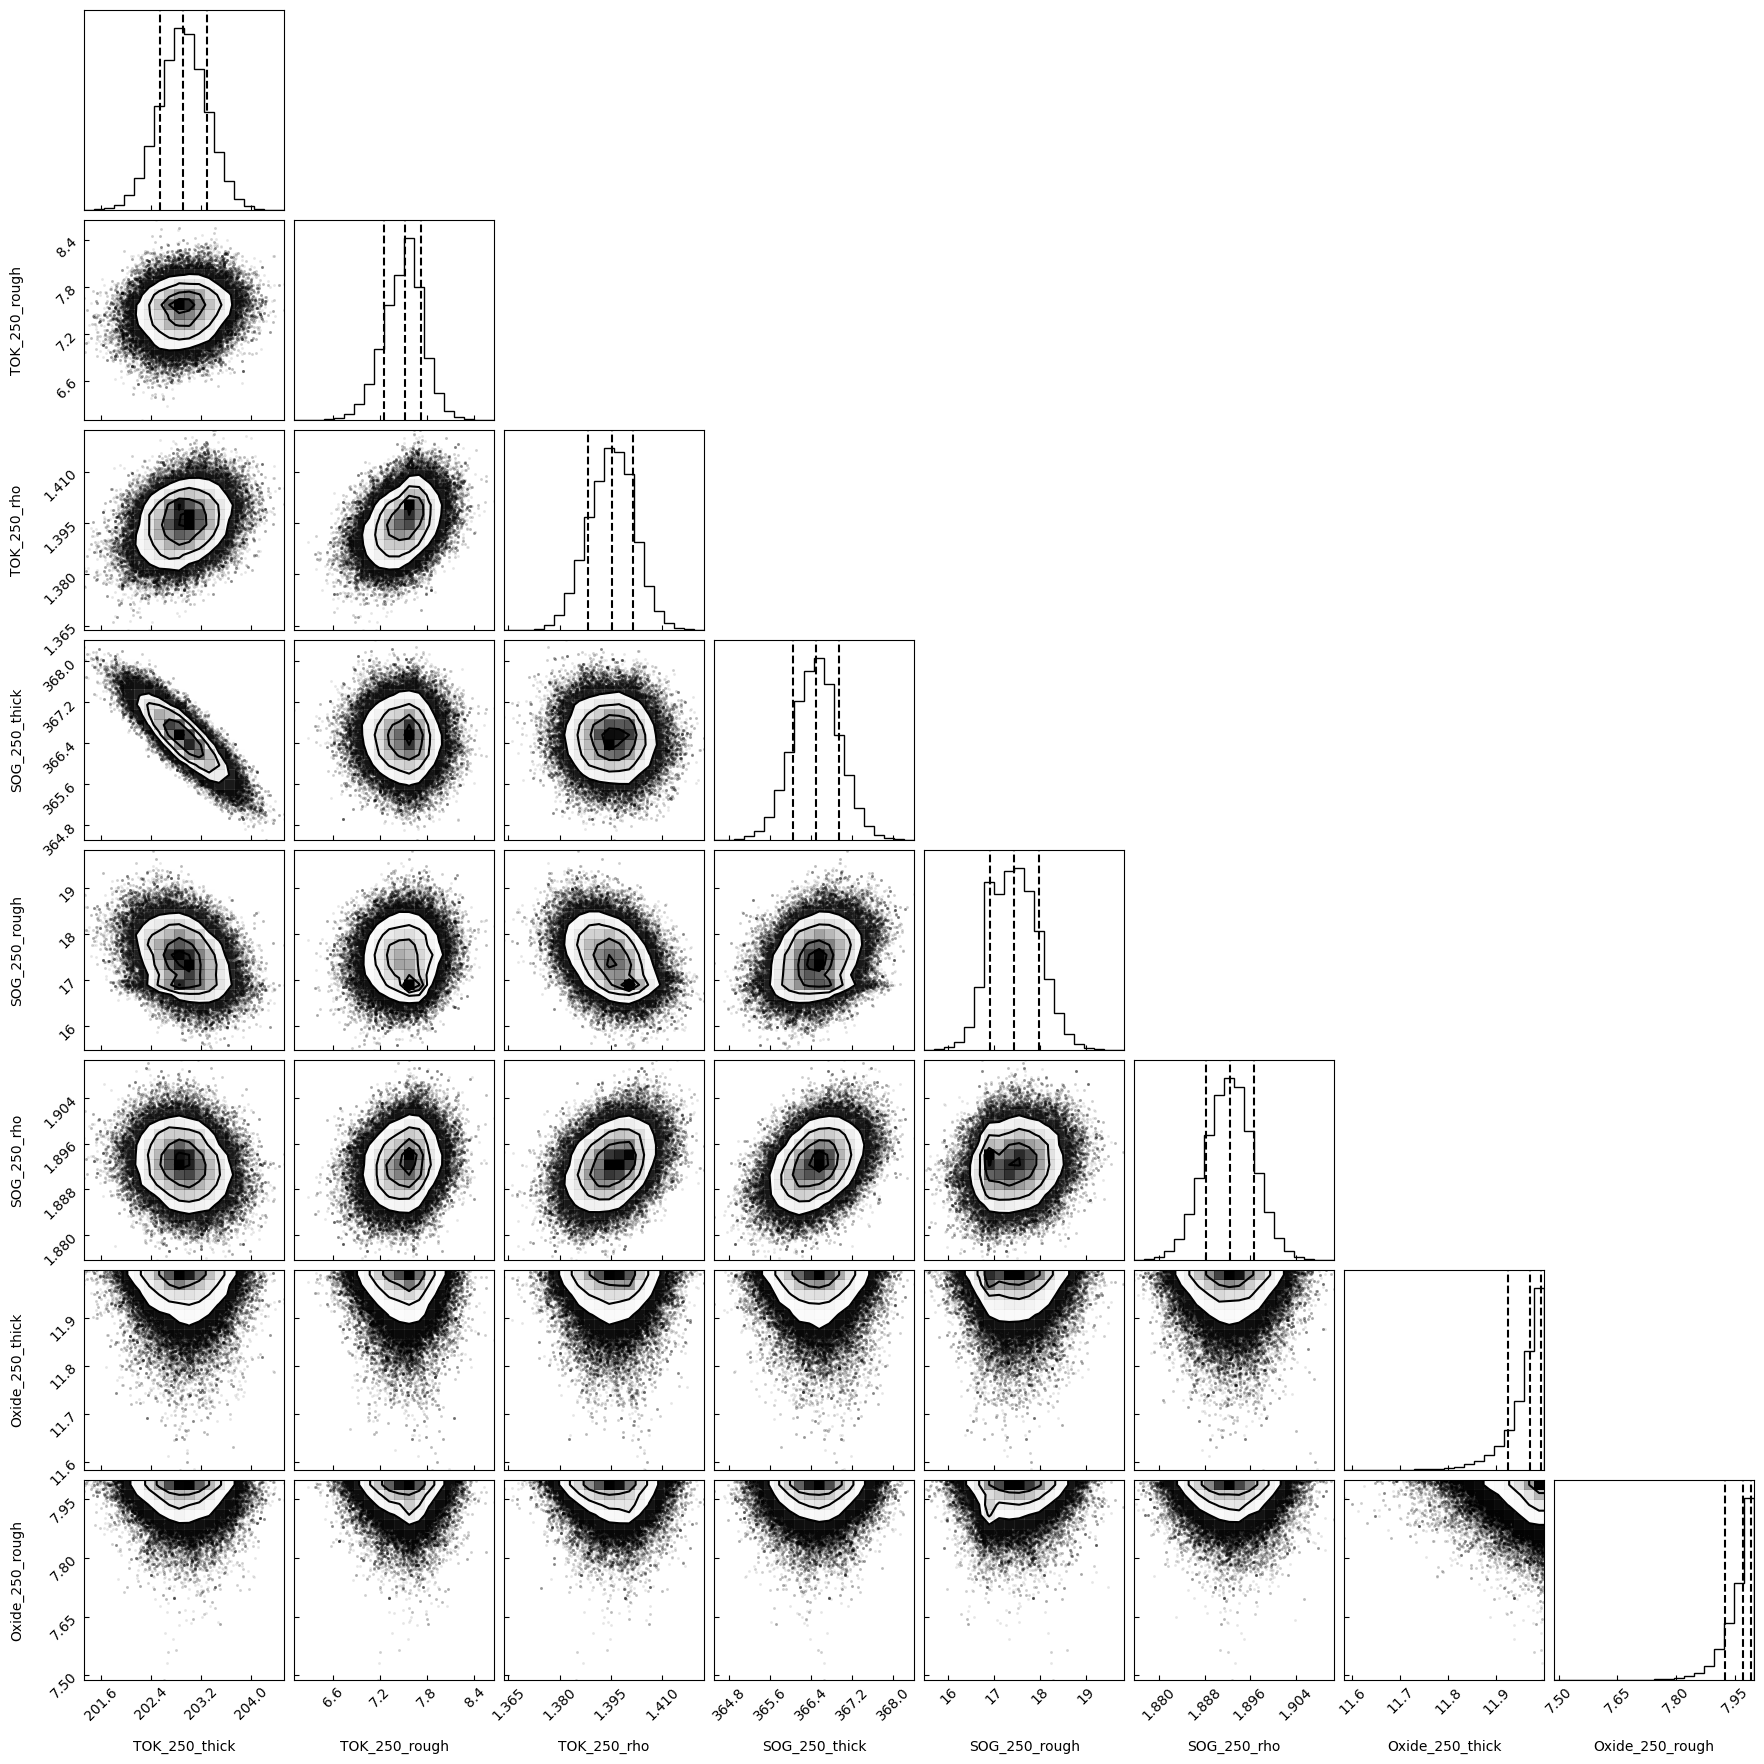

In [19]:
obj_exposed_chained.corner()
plt.show()

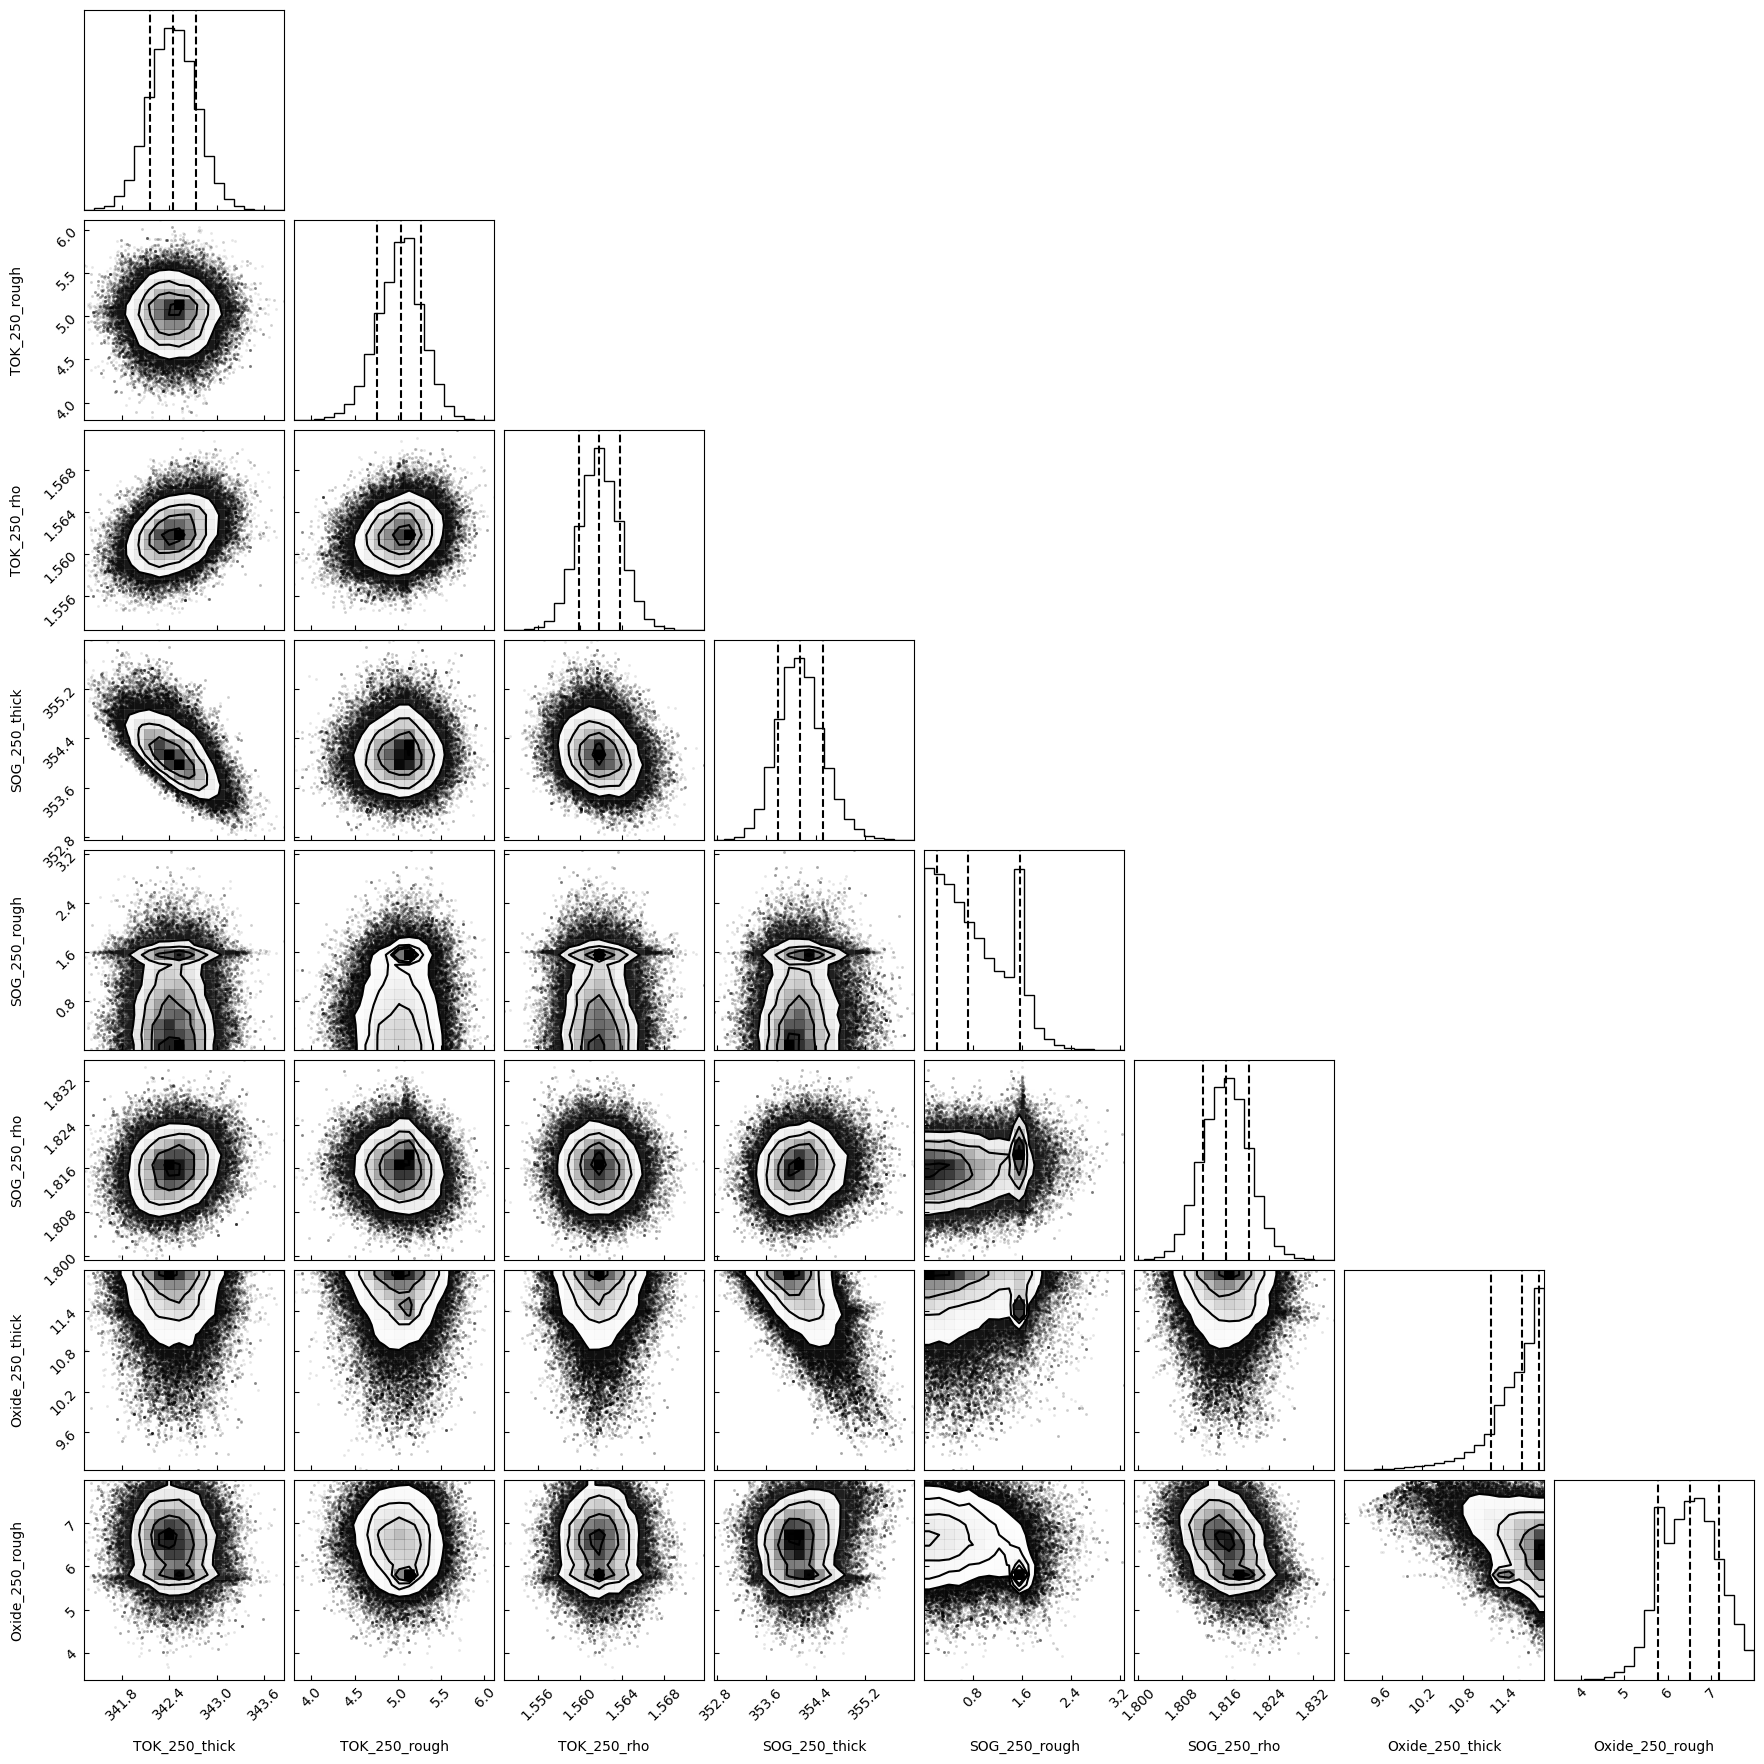

In [20]:
obj_unexposed_chained.corner()
plt.show()